Кадерова Надия, 316 группа

In [126]:
import pandas as pd
import yfinance as yf
import time
import numpy as np
import matplotlib.pyplot as plt

Дата начала импорта:

In [127]:
start_day = '2022-01-01'

Исторические ежедневные цены закрытия для одного тикера:

In [128]:
def get_One_Asset(company,start_day):
    df = pd.DataFrame()
    returns = yf.Ticker(company)
    data = returns.history(period="1y",start=start_day)
    df.index=data.index
    df[company]=data.Close
    return df

Получаем данные цен закрытия для AOS A. O. Smith Industrials:

In [129]:
company = 'AOS'
asset = get_One_Asset(company,start_day)
asset.head()

,AOS
Date,
2022-01-03 00:00:00-05:00,81.622810
2022-01-04 00:00:00-05:00,82.980408
2022-01-05 00:00:00-05:00,81.593498
2022-01-06 00:00:00-05:00,82.140457
2022-01-07 00:00:00-05:00,81.212593


Найдем количество:

In [130]:
asset.size

288

In [131]:
rates = np.zeros(asset.size)

In [132]:
for i in range(asset.size-1):
    rates[i] = (asset['AOS'][i+1]/asset['AOS'][i]) - 1

In [133]:
rates[0]

0.01663257299061116

Получили доходности

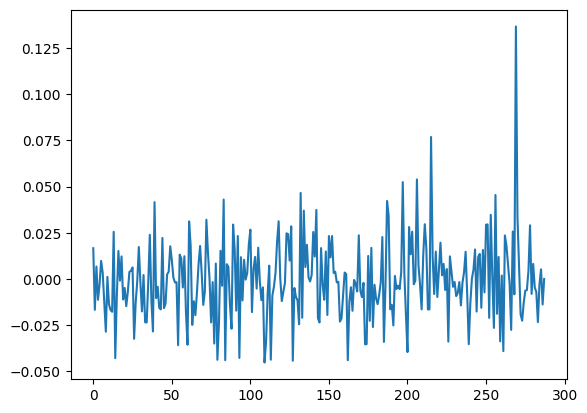

In [134]:
plt.plot(rates)

Имеем выборку доходностей, из нее возьмем процесс x:

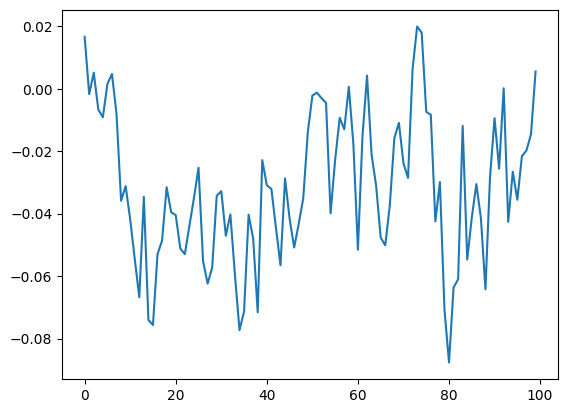

In [135]:
n = 100
x = np.zeros(n)
fi = 0.9
for i in range (0,n):
    x[i] = fi * x[i-1] + rates[i]
plt.plot(x)    

Проверим гипотезу случайности, проведя тест на случайность:

In [136]:
import pymannkendall as mk

In [137]:
mk.original_test(rates)

Mann_Kendall_Test(trend='no trend', h=False, p=0.23931666840546195, z=1.1766964922937562, Tau=0.04653019744483159, s=1923.0, var_s=2667951.0, slope=1.562308949668675e-05, intercept=-0.004058354928872998)

Видим, что гипотеза случайности не отвергается. Посмотрим на результат для x:

In [138]:
mk.original_test(x)

Mann_Kendall_Test(trend='no trend', h=False, p=0.14696292831126367, z=1.4503428755858905, Tau=0.09858585858585858, s=488.0, var_s=112750.0, slope=0.00013557883897522718, intercept=-0.0391421625946948)

Получили, что для x гипотеза случайности так же не отвергается. 

# Вывод:

Гипотеза случайности не отвергается.

Проверим гипотезу однородности для части данных доходностей, для этого проведем тест Уилкоксона:

Сначала разделим данные доходностей на 2 части: до 1 августа 2022 года и последующих (1 июля 2022 года не берем границей, потому что в таком случае выборки будут состоять из разного кол-ва элементов и тест Уилкоксона нельзя будет применить)

In [139]:
asset.iloc[0]

AOS    81.62281
Name: 2022-01-03 00:00:00-05:00, dtype: float64

In [15]:
asset.iloc[123]

AOS    53.843548
Name: 2022-06-30 00:00:00-04:00, dtype: float64

In [16]:
asset.iloc[144]

AOS    61.265999
Name: 2022-08-01 00:00:00-04:00, dtype: float64

Видно, в какой момент будет проходить граница частей, тогда разделим доходности:

In [140]:
rates1 = np.zeros(144)
rates2 = np.zeros(144)

In [141]:
for i in range(rates1.size):
    rates1[i] = rates[i]
for i in range(rates2.size):
    rates2[i] = rates[i + rates1.size]    

In [142]:
print(rates1.size)
print(rates2.size)

144
144


In [20]:
import scipy.stats as stats

In [143]:
stats.wilcoxon(rates1, rates2)

WilcoxonResult(statistic=4965.0, pvalue=0.6110693468012701)

Pvalue больше заданного уровня значимости - 0.05.

# Вывод:


Гипотеза об однородности двух частей выборки не отвергается.

Определим тип распределения для доходностей:

In [69]:
from fitter import Fitter, get_common_distributions, get_distributions


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 31.72it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,1502.102090,154.965582,498.330014,inf,0.044321,6.074582e-01
norm,1510.003722,491.779600,488.515112,inf,0.060762,2.286498e-01
lognorm,1512.682384,96.018043,494.688516,inf,0.049228,4.728466e-01
burr,6209.223195,-208.230922,907.051054,inf,0.283979,4.804335e-21
gamma,8384.461288,-100.033860,987.887266,inf,0.505314,1.247656e-68


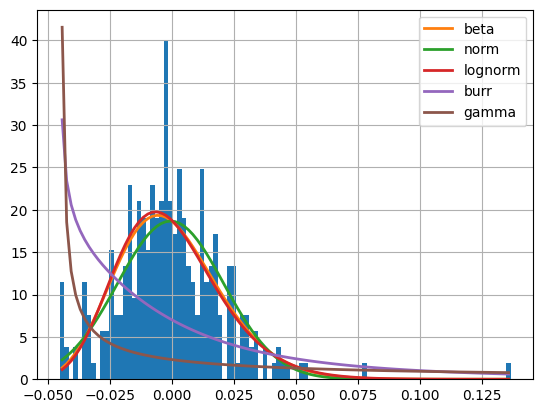

In [144]:
f = Fitter(rates,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

Можно предположить, что распределение нормальное, либо логистическое

Разделим случайно выборку на 2 части: тренировочную и тестовую:

In [145]:
rates_new = rates

In [192]:
np.random.shuffle(rates_new)
training, test = rates_new[:80], rates_new[80:]

In [169]:
training.size

80

In [170]:
test.size

208

Методом максимального правдоподобия оценим параметры предполагаемого распределения по тренировочной части выборки:

In [117]:
from scipy.stats import norm, lognorm

In [193]:
norm.fit(training)

(-0.000430391532618124, 0.01703842003920989)

In [194]:
lognorm.fit(training)

(0.06047927678021531, -0.28184098031048915, 0.2808962187907099)

In [195]:
r1 = np.mean(training)
r1

-0.000430391532618124

In [196]:
r2 = np.std(training)
r2

0.01703842003920989

mean и std совпадают с параметрами нормального распределения

Проверим гипотезу согласия с предложенным распределением всей выборки критериями Колмогорова-Смирнова и Хи-квадрат Пирсона:

Предположили, что распредение нормальное. Проверим это.

In [43]:
from scipy.stats import kstest

In [198]:
kstest(rates, 'norm')

KstestResult(statistic=0.4819648337341212, pvalue=4.456023395736342e-62, statistic_location=-0.04522286724479796, statistic_sign=-1)

pvalue < 0.05, а значит гипотезу нормальности отвергаем. Теперь проверим с параметрами, полученными из ММП:

In [199]:
stats.kstest(rates,'norm',(r1,r2))

KstestResult(statistic=0.053275098128660714, pvalue=0.37396377311076545, statistic_location=-0.0009262458464918133, statistic_sign=1)

Видим, что pvalue > 0.05, а значит гипотезу нормальности не отвергаем. С учетом оценки параметров получили разные результаты. В общем случае это может привести к ошибке, потому что оценивать параметры распределения нужно как можно более независимо от данной выборки. Мы видим, что оценка параметров привела к сильному увеличению значения p-value

Теперь посмотрим с параметрами, полученными из ММП для логистического распределения:

In [201]:
stats.kstest(rates,'lognorm',(0.06047927678021531, -0.28184098031048915, 0.2808962187907099))

KstestResult(statistic=0.049589989970155623, pvalue=0.4634801681115187, statistic_location=-0.03380007857555978, statistic_sign=1)

pvalue > 0.05, а значит гипотезу lognorm распределения не отвергаем. 

Критерий Хи-квадрат Пирсона:

In [202]:
stats.chisquare(rates)

Power_divergenceResult(statistic=-230.50757381319295, pvalue=1.0)

In [ ]:
Видим, что pvalue > 0.05, а значит гипотезу нормальности отвергнуть нельзя.

# Вывод:

Применяя различные тесты для проверки нормальности распределения, получили абсолютно противоположные результаты, в одном случае гипотеза нормальности отвергается, а в другом нет, в одном случае учитывалась оценка параметров. Критерий хи-квадрат Пирсона оценивать как простые, так и сложные гипотезы, в этом его преимущество. Также получаем, что доходности не могут иметь логистическое распределение, что отвергается критерием Колмогорова-Смирнова. То, что параметры получили из оценки тренировочной части выборки, полученной случайно, тоже повлияло на результат. Получатся, что результаты (отвергаем или принимаем гипотезу) зависят от параметров, от их оценки. Оценка параметров по данной выборке может привести к неверным результатам применения критериев.